## Import libraries, load ASR function, unzip dataset, and download model

In [1]:
!pip install -r requirements.txt

  Using cached transformers-4.23.1-py3-none-any.whl (5.3 MB)
  Attempting uninstall: transformers
    Found existing installation: transformers 4.24.0
    Uninstalling transformers-4.24.0:
      Successfully uninstalled transformers-4.24.0


In [3]:
import os
import transformers
import torchaudio
import numpy as np
import sentencepiece
import pandas as pd
import csv
import regex as re
import pandas as pd

from pyctcdecode import build_ctcdecoder
from transformers import Wav2Vec2ProcessorWithLM, Wav2Vec2ForCTC, Wav2Vec2CTCTokenizer, Wav2Vec2FeatureExtractor, AutoTokenizer, AutoModelForSeq2SeqLM
from scipy.io.wavfile import write
import matplotlib.pyplot as plt

This function performs text generation from audio files in wav format.
It loads the audio file into an array, adjust the sample rate to the one required by the model (16000) and run it into the model that generates text from the waveform.

In [2]:
def asr_model(wav_file, model, processor):
    waveform, sample_rate = torchaudio.load(wav_file)
    resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000, resampling_method='sinc_interpolation')
    # Downsampling is required to match the model's frequency, i.e.
    # the frequency of the dataset the model was trained on.
    speech_array = resampler(waveform).squeeze().numpy()
    inputs = processor(speech_array, sampling_rate=16000, return_tensors="pt")['input_values']
    # Detach the tensors first (otherwise, they require gradients
    # to be computed); also, since we're simulating the inference
    # squeeze the resulting array at the first dimension (batch_size),
    # otherwise, leave it as is, and call batch_decode() instead.
    outputs = model(inputs)['logits'].detach().numpy().squeeze(0)
    return(processor.decode(outputs).text)

Download model and processor to be used in the function above.

In [3]:
model = Wav2Vec2ForCTC.from_pretrained("Yehor/wav2vec2-xls-r-300m-uk-with-small-lm")

In [4]:
processor = Wav2Vec2ProcessorWithLM.from_pretrained("Yehor/wav2vec2-xls-r-300m-uk-with-small-lm")

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/huggingface_hub/utils/_deprecation.py:97: FutureWarning: Deprecated argument(s) used in 'snapshot_download': allow_regex. Will not be supported from version '0.12'.

Please use `allow_patterns` and `ignore_patterns` instead.
  warnings.warn(message, FutureWarning)


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Loading the LM will be faster if you build a binary file.
Reading /home/studio-lab-user/.cache/pyctcdecode/models--Yehor--wav2vec2-xls-r-300m-uk-with-small-lm/snapshots/bbd936400e7566ba44560440aa4abd05b5983c17/language_model/5gram_correct.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
****************************************************************************************************


In [ ]:
# Unzip file
!unzip VOXFORG.zip

## Prepare dataset

After extracting the files, change directory to the files location. List all the directories in the location to access the files from them.

In [5]:
# Save list of directories in the dataset folder

%cd '/home/studio-lab-user/sagemaker-studiolab-notebooks/VOXFORG'

folders = os.listdir()
folders = folders[:-1]

/home/studio-lab-user/sagemaker-studiolab-notebooks/VOXFORG


Create a variable to store the file paths and their corresponding transcripts. The variable is a list containing sublists for each pair if path and transcript.
Then, open the file in each directory of the list created before. For each line of the opened file, use regular expressions to extract the path and the transcript from the line. Store them in temporary variables. Because the output from the findall function is a list, select the index 0 of each list, strip the extra space in the line, and append them as a sublist of the list created before.

In [6]:
# Open text files in the dataset folders and save each row in a list (splitting the file path and the transcription into an inner list)
text = []
for f in folders:
    file = open(f+'/etc/txt.done.data', 'r', encoding='utf8')
    for line in file:
        line = line.lstrip('/')
        path = re.findall('^(.+\.wav)', line)
        transcript = re.findall('^.+\.wav(.+)', line)
        l = [path[0], transcript[0].strip(' ')]
        text.append(l)

Check if the length of the list matches the size of the dataset (number of wav files). Check if the path and the transcript were splitted correctly by printing the first line.

In [7]:
print(len(text))

380


In [8]:
print(text[0])

['VOXFORG/Alias-20160403-lmx/wav/spk_id_8812551_16142703404370.wav', 'завжди знайдуться люди які зроблять тобі боляче треба продовжувати довіряти людям просто бути трохи обережнішим']


## Generate text

Change the working directory again to create a csv file that will store all the paths, transcripts, and generated text from the ASR model. First, write a header to the file. Next, the loop calls the function to generate text. The output is saved into a variable that is appended to the list containing the path and transcript for the sentence.
Lastly, the list with all the sentences, containing path + transcript + generated text, is written to the csv file.

In [7]:
%cd '/home/studio-lab-user/sagemaker-studiolab-notebooks/'

/home/studio-lab-user/sagemaker-studiolab-notebooks


In [8]:
# Append generated text in the list
with open('voxforg_transcription_generated-text.csv', 'w', encoding='UTF8', newline='\n') as f:
    writer = csv.writer(f)

    # write the header
    writer.writerow(['path', 'transcription', 'generated_text'])

for i in range(0, len(text)):
    gen_text = asr_model(text[i][0], model, processor)
    line = [text[i][0],text[i][1],gen_text]
    
    with open('voxforg_transcription_generated-text.csv', 'a', encoding='UTF8') as f:
        writer = csv.writer(f)

        # write the data
        writer.writerow(line)

['VOXFORG/anonymous-20131220-hzd/wav/spk_id_1484577_16142703495704.wav', 'книгою книг виданих цьогоріч є архітектурно-культурологічне дослідження леви львова яке побачило світ завдяки ініціативі та зусиллям галереї равлик', 'книгою книг виданий цього річ є архітектурно культуру логічне дослідження левельвова яке побачили світ завдяки ініціативи та зусиллям галереїравлик']
['VOXFORG/anonymous-20131220-hzd/wav/spk_id_1484577_16142703497003.wav', 'при цьому вона старається плекати такий духовний та емоційний клімат який сприяє пошуку власного художнього слова', 'при цьому вона старається плекати такий духовний та емоційний клімат який сприяє пошуку власного художнього слова']
['VOXFORG/anonymous-20131220-hzd/wav/spk_id_1484577_16142703497553.wav', "а говорити є про що експозиція ненав'язлива легка сонячна", "а говорити є про що експозиція не нав'язлива легка сонячна"]
['VOXFORG/anonymous-20131220-hzd/wav/spk_id_1484577_16142703497943.wav', 'нині у львові маємо шанс запізнати людину яка у 

## Length Classification

In [4]:
Load the csv containing the wav path, transcript, and generated text as a pandas dataframe.

In [5]:
transcripts = pd.read_csv("voxforg_transcription_generated-text.csv", encoding='utf-8')

In [6]:
transcripts.head()

,path,transcription,generated_text
0,VOXFORG/Alias-20160403-lmx/wav/spk_id_8812551_...,завжди знайдуться люди які зроблять тобі боляч...,завжди знайдуться люди які зроблять тобі боляч...
1,VOXFORG/Alias-20160403-lmx/wav/spk_id_8812551_...,один хлопець поступається місцем знайомій дівч...,один хлопець поступається місцем знайомі дівчи...
2,VOXFORG/Alias-20160403-lmx/wav/spk_id_8812551_...,тож не дивно що протягом тижня львовом поширюв...,то ж не дивно що протягом тижня львова поширюв...
3,VOXFORG/Alias-20160403-lmx/wav/spk_id_8812551_...,будить мій тато молодшого брата до школи,будетмітато молодшого брата до школи
4,VOXFORG/Alias-20160403-lmx/wav/spk_id_8812551_...,скільки коштуватиме організаторам дійство за у...,скільки коштувати організаторам дійство за уча...


To calculate the length difference between the transcript and the generated text, first remove the newline character, if it is present in the transcript. Then, subtract the length of the generated text from the transcript length. Append the result to a list and save the list as a column in the dataframe.

In [7]:
# Calculate length difference between transcripts
length = []
for i in range(len(transcripts['path'])):
    transcripts['transcription'][i] = transcripts['transcription'][i].rstrip('\n')
    length.append(len(transcripts['transcription'][i]) - len(transcripts['generated_text'][i]))

In [8]:
# Create column in dataset
transcripts['length_diff'] = length
transcripts.head()

,path,transcription,generated_text,length_diff
0,VOXFORG/Alias-20160403-lmx/wav/spk_id_8812551_...,завжди знайдуться люди які зроблять тобі боляч...,завжди знайдуться люди які зроблять тобі боляч...,0
1,VOXFORG/Alias-20160403-lmx/wav/spk_id_8812551_...,один хлопець поступається місцем знайомій дівч...,один хлопець поступається місцем знайомі дівчи...,1
2,VOXFORG/Alias-20160403-lmx/wav/spk_id_8812551_...,тож не дивно що протягом тижня львовом поширюв...,то ж не дивно що протягом тижня львова поширюв...,1
3,VOXFORG/Alias-20160403-lmx/wav/spk_id_8812551_...,будить мій тато молодшого брата до школи,будетмітато молодшого брата до школи,4
4,VOXFORG/Alias-20160403-lmx/wav/spk_id_8812551_...,скільки коштуватиме організаторам дійство за у...,скільки коштувати організаторам дійство за уча...,0


Based on the difference, classificate each transcript into one of three categories: incomplete (difference is equal or less than -10), inconclusive (difference is equal to or less than -5), or complete (difference is greater than -5). Save the classification as a new column of the dataframe and then save the dataframe as a csv file.

In [10]:
# Classificate transcripts according to length difference

transcripts['length_cat'] = [0 for x in range(380)]

for i in range(len(transcripts['length_diff'])):
  if transcripts['length_diff'][i] <= -10:
    transcripts['length_cat'][i] = 'incomplete'
  elif transcripts['length_diff'][i] <= -5:
    transcripts['length_cat'][i] = 'inconclusive'
  else:
    transcripts['length_cat'][i] = 'complete'
    

transcripts.to_csv('transcripts_length_cat_voxforg.csv', encoding='utf-8')
transcripts.head()

/tmp/ipykernel_125/3696879790.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transcripts['length_cat'][i] = 'complete'


,path,transcription,generated_text,length_diff,length_cat
0,VOXFORG/Alias-20160403-lmx/wav/spk_id_8812551_...,завжди знайдуться люди які зроблять тобі боляч...,завжди знайдуться люди які зроблять тобі боляч...,0,complete
1,VOXFORG/Alias-20160403-lmx/wav/spk_id_8812551_...,один хлопець поступається місцем знайомій дівч...,один хлопець поступається місцем знайомі дівчи...,1,complete
2,VOXFORG/Alias-20160403-lmx/wav/spk_id_8812551_...,тож не дивно що протягом тижня львовом поширюв...,то ж не дивно що протягом тижня львова поширюв...,1,complete
3,VOXFORG/Alias-20160403-lmx/wav/spk_id_8812551_...,будить мій тато молодшого брата до школи,будетмітато молодшого брата до школи,4,complete
4,VOXFORG/Alias-20160403-lmx/wav/spk_id_8812551_...,скільки коштуватиме організаторам дійство за у...,скільки коштувати організаторам дійство за уча...,0,complete


To have a picture about the completeness of the transcripts, count and plot the values in each category.

In [11]:
# Count n of transcripts per category
transcripts['length_cat'].value_counts()

complete        378
inconclusive      2
Name: length_cat, dtype: int64

<AxesSubplot: >

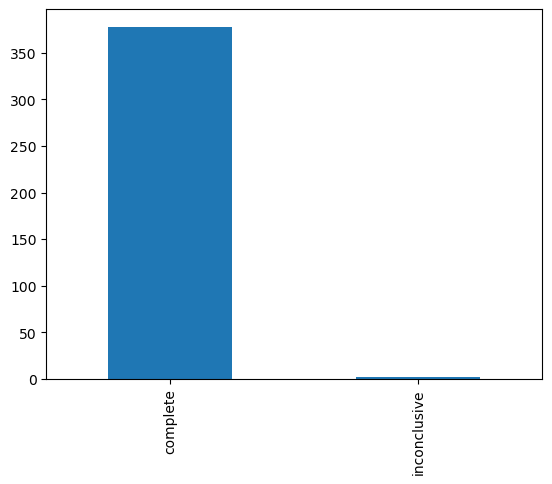

In [12]:
transcripts['length_cat'].value_counts().plot.bar()

Finally, select only the transcripts classificated as incomplete or inconclusive and save them into a text file for manual inspection. The text file contains the path, the transcript, and the generated text, each in a different line, with a blank line separating each sentence.

In [13]:
# Select only transcripts in the incomplete and inconclusive categories
txt = transcripts.loc[(transcripts['length_cat'] == 'incomplete') | (transcripts['length_cat'] == 'inconclusive')]
txt.head()

,path,transcription,generated_text,length_diff,length_cat
339,VOXFORG/Taras-20160318-ewy/wav/spk_id_1714329_...,жах не в тому що щось змінеться жах у тому що ...,жах не в тому що щось ставиться а жаху тому що...,-6,inconclusive
359,VOXFORG/Taras-20160318-qgc/wav/spk_id_7514084_...,книгою книг виданих цьогоріч є архітектурно-ку...,книгою книг видавив цьогоріч є архітектурникул...,-7,inconclusive


In [14]:
# Save in a text file
with open('transcripts_voxforg.txt', 'w', encoding='utf-8') as f:
    for t in range(len(txt)):
        f.write(txt.iloc[t,0]+'\n')
        f.write(txt.iloc[t,1]+'\n')
        f.write(txt.iloc[t,2]+'\n')
        f.write('\n\n')